# Computing Variance Online (one-shot observation)

We'll compare Welford's and Chan et al's methods of estimating variance online against the stadard two-phase approach.
By computing the variance online we mean looking at each data point once, and only once.


  - [Welfords' algorithm](https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Welford's_online_algorithm): designed to compute the variance using a one-pass approach
  - [Chan et al' algorithm](https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm): designed to combine variances computed from different sub-samples of a collection of values

To that end, we'll experiment with different sample sizes, and compare how the mean and variance estimated through the online approach differ from the two-phase approach, i.e. computing the mean in a first pass, and using that to compute the variance in a second pass.

In [1]:
import math
import numpy as np
import scipy.stats
from typing import Any, Callable, Tuple, Iterable, List, Union

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

In [4]:
sns.set_style("whitegrid")

## Online Variance

We define a class to accumulate the mean and M2 values, as per Welford's method.

In [5]:
class OnlineStats(object):
    """
    See Welford's online algorithm for variance:
    https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#On-line_algorithm
    """

    def __init__(self):
        self._count = 0
        self._mean = 0.0
        self._m2 = 0.0

    def update(self, new_value: Union[int, float]) -> None:
        """
        Updates the arithmetic mean (using a continuous mean formula) and the variance
        using Welfords's continuous formula for variance.
        """

        existing_agg = (self._count, self._mean, self._m2)
        self._count, self._mean, self._m2 = welford_online_variance_update(
            existing_agg, new_value
        )

    def mean(self) -> float:
        return self._mean

    def sample_variance(self) -> float:
        return float("nan") if self._count < 2 else self._m2 / (self._count - 1)

    def variance(self) -> float:
        return float("nan") if self._count < 2 else self._m2 / self._count

    def sample_std(self) -> float:
        return math.sqrt(self.sample_variance())

    def std(self) -> float:
        return math.sqrt(self.variance())

    def sample_size(self) -> int:
        return self._count

    @property
    def m2(self):
        return self._m2
    
    @staticmethod
    def create(count: int, mean: float, m2: float):
        rss = OnlineStats()
        rss._count = count
        rss._mean = mean
        rss._m2 = m2
        return rss    


Next, we define methods to combine different stats from sub-samples, as per Chan et. al's algorithm.

In [6]:
def welford_online_variance_update(
    existing_agg: Tuple[int, float, float], new_value: Union[int, float]
):
    (count, mean, m2) = existing_agg
    new_count = count + 1
    delta = new_value - mean
    new_mean = mean + delta / new_count
    delta2 = new_value - new_mean
    new_m2 = m2 + delta * delta2
    return new_count, new_mean, new_m2

In [7]:
def stats_concurrent(*arrays):
    sample_stats = []
    for array in arrays:
        rss = OnlineStats()
        for value in array:
            rss.update(value)
        sample_stats.append(rss)

    result = combine_multiple_online_stats(sample_stats)
    return result.mean(), result.variance()

In [8]:
def combine_multiple_online_stats(online_stats_list: Iterable[OnlineStats]) -> OnlineStats:
    result = OnlineStats()
    for online_stats in online_stats_list:
        result = combine_online_stats(result, online_stats)
    return result

In [9]:
def combine_online_stats(online_stats_a: OnlineStats, online_stats_b: OnlineStats) -> OnlineStats:
    """
    Combines running sample stats instances using Chan et al.' algorithm.
    """
    count = online_stats_a.sample_size() + online_stats_b.sample_size()
    delta = online_stats_b.mean() - online_stats_a.mean()
    mean = online_stats_a.mean() + delta * online_stats_b.sample_size() / count
    m2 = (
        online_stats_a.m2
        + online_stats_b.m2
        + (delta * delta) * ((online_stats_a.sample_size() / online_stats_b.sample_size()) / count)
    )
    return OnlineStats.create(count, mean, m2)

In [10]:
def split(array: np.ndarray, splits: int) -> List[np.ndarray]:
    size = math.floor(len(array) / splits)
    return [
        array[i * size : (i + 1) * size if i < splits - 1 else len(array)]
        for i in range(splits)
    ]

## Simulting Online Variance

To compare the mean and variance using Welford's and Chan's et al's methods againt the two-phase approach, we'll generate data from the (1) standard normal and (2) binomial distributions.

In [11]:
def simulate(rounds: int, num_samples: int, sub_sample_range: np.ndarray, 
             data_and_stats_fn: Callable[[int, int], Tuple[np.ndarray, Tuple[float, float]]]):
    mean_deltas, variance_deltas = [], []
    for idx in range(rounds):
        data, s_stats = data_and_stats_fn(idx, num_samples)
        sub_samples = split(data, np.random.choice(sub_sample_range, size=1).item())
        c_stats = stats_concurrent(*sub_samples)
        mean_deltas.append(delta(s_stats[0], c_stats[0]))
        variance_deltas.append(delta(s_stats[1], c_stats[1]))
    return mean_deltas, variance_deltas

In [12]:
def delta(a: float, b: float) -> float:
    return (a - b) / a

In [13]:
def simulate_and_plot(rounds: int, possible_num_samples: List[int], sub_sample_range: np.ndarray, 
                      data_and_stats_fn: Callable[[int, int], Tuple[np.ndarray, Tuple[float, float]]],
                      dist_type: str) -> Any:
    _, axes = plt.subplots(len(possible_num_samples), 2, figsize=(16, 5*len(possible_num_samples)), dpi=300)
    labels = ["Mean", "Variance"]
    
    for row, num_samples in enumerate(possible_num_samples):
        mean_deltas, variance_deltas = simulate(rounds, num_samples, sub_sample_range, data_and_stats_fn)
        for col, (values, label) in enumerate(zip([mean_deltas, variance_deltas], labels)):
            ax = sns.distplot(values, ax=axes[row, col])
            _ = ax.set_title(f'{label} Delta, {dist_type} distribution (pp), m={num_samples}')

### Stardard Normal Distribution

And as a baseline, we use numpy's mean and variance to compare (it's a two-pass implementation)

In [14]:
def snd_stats(array: np.ndarray) -> Tuple[float, float]:
    """Stats for standard normal distribution"""
    return np.mean(array).item(), np.var(array).item()

In [15]:
def snd_data_and_stats(idx: int, num_samples: int) -> np.ndarray:
    del idx
    data = np.random.randn(num_samples)
    return data, snd_stats(data)

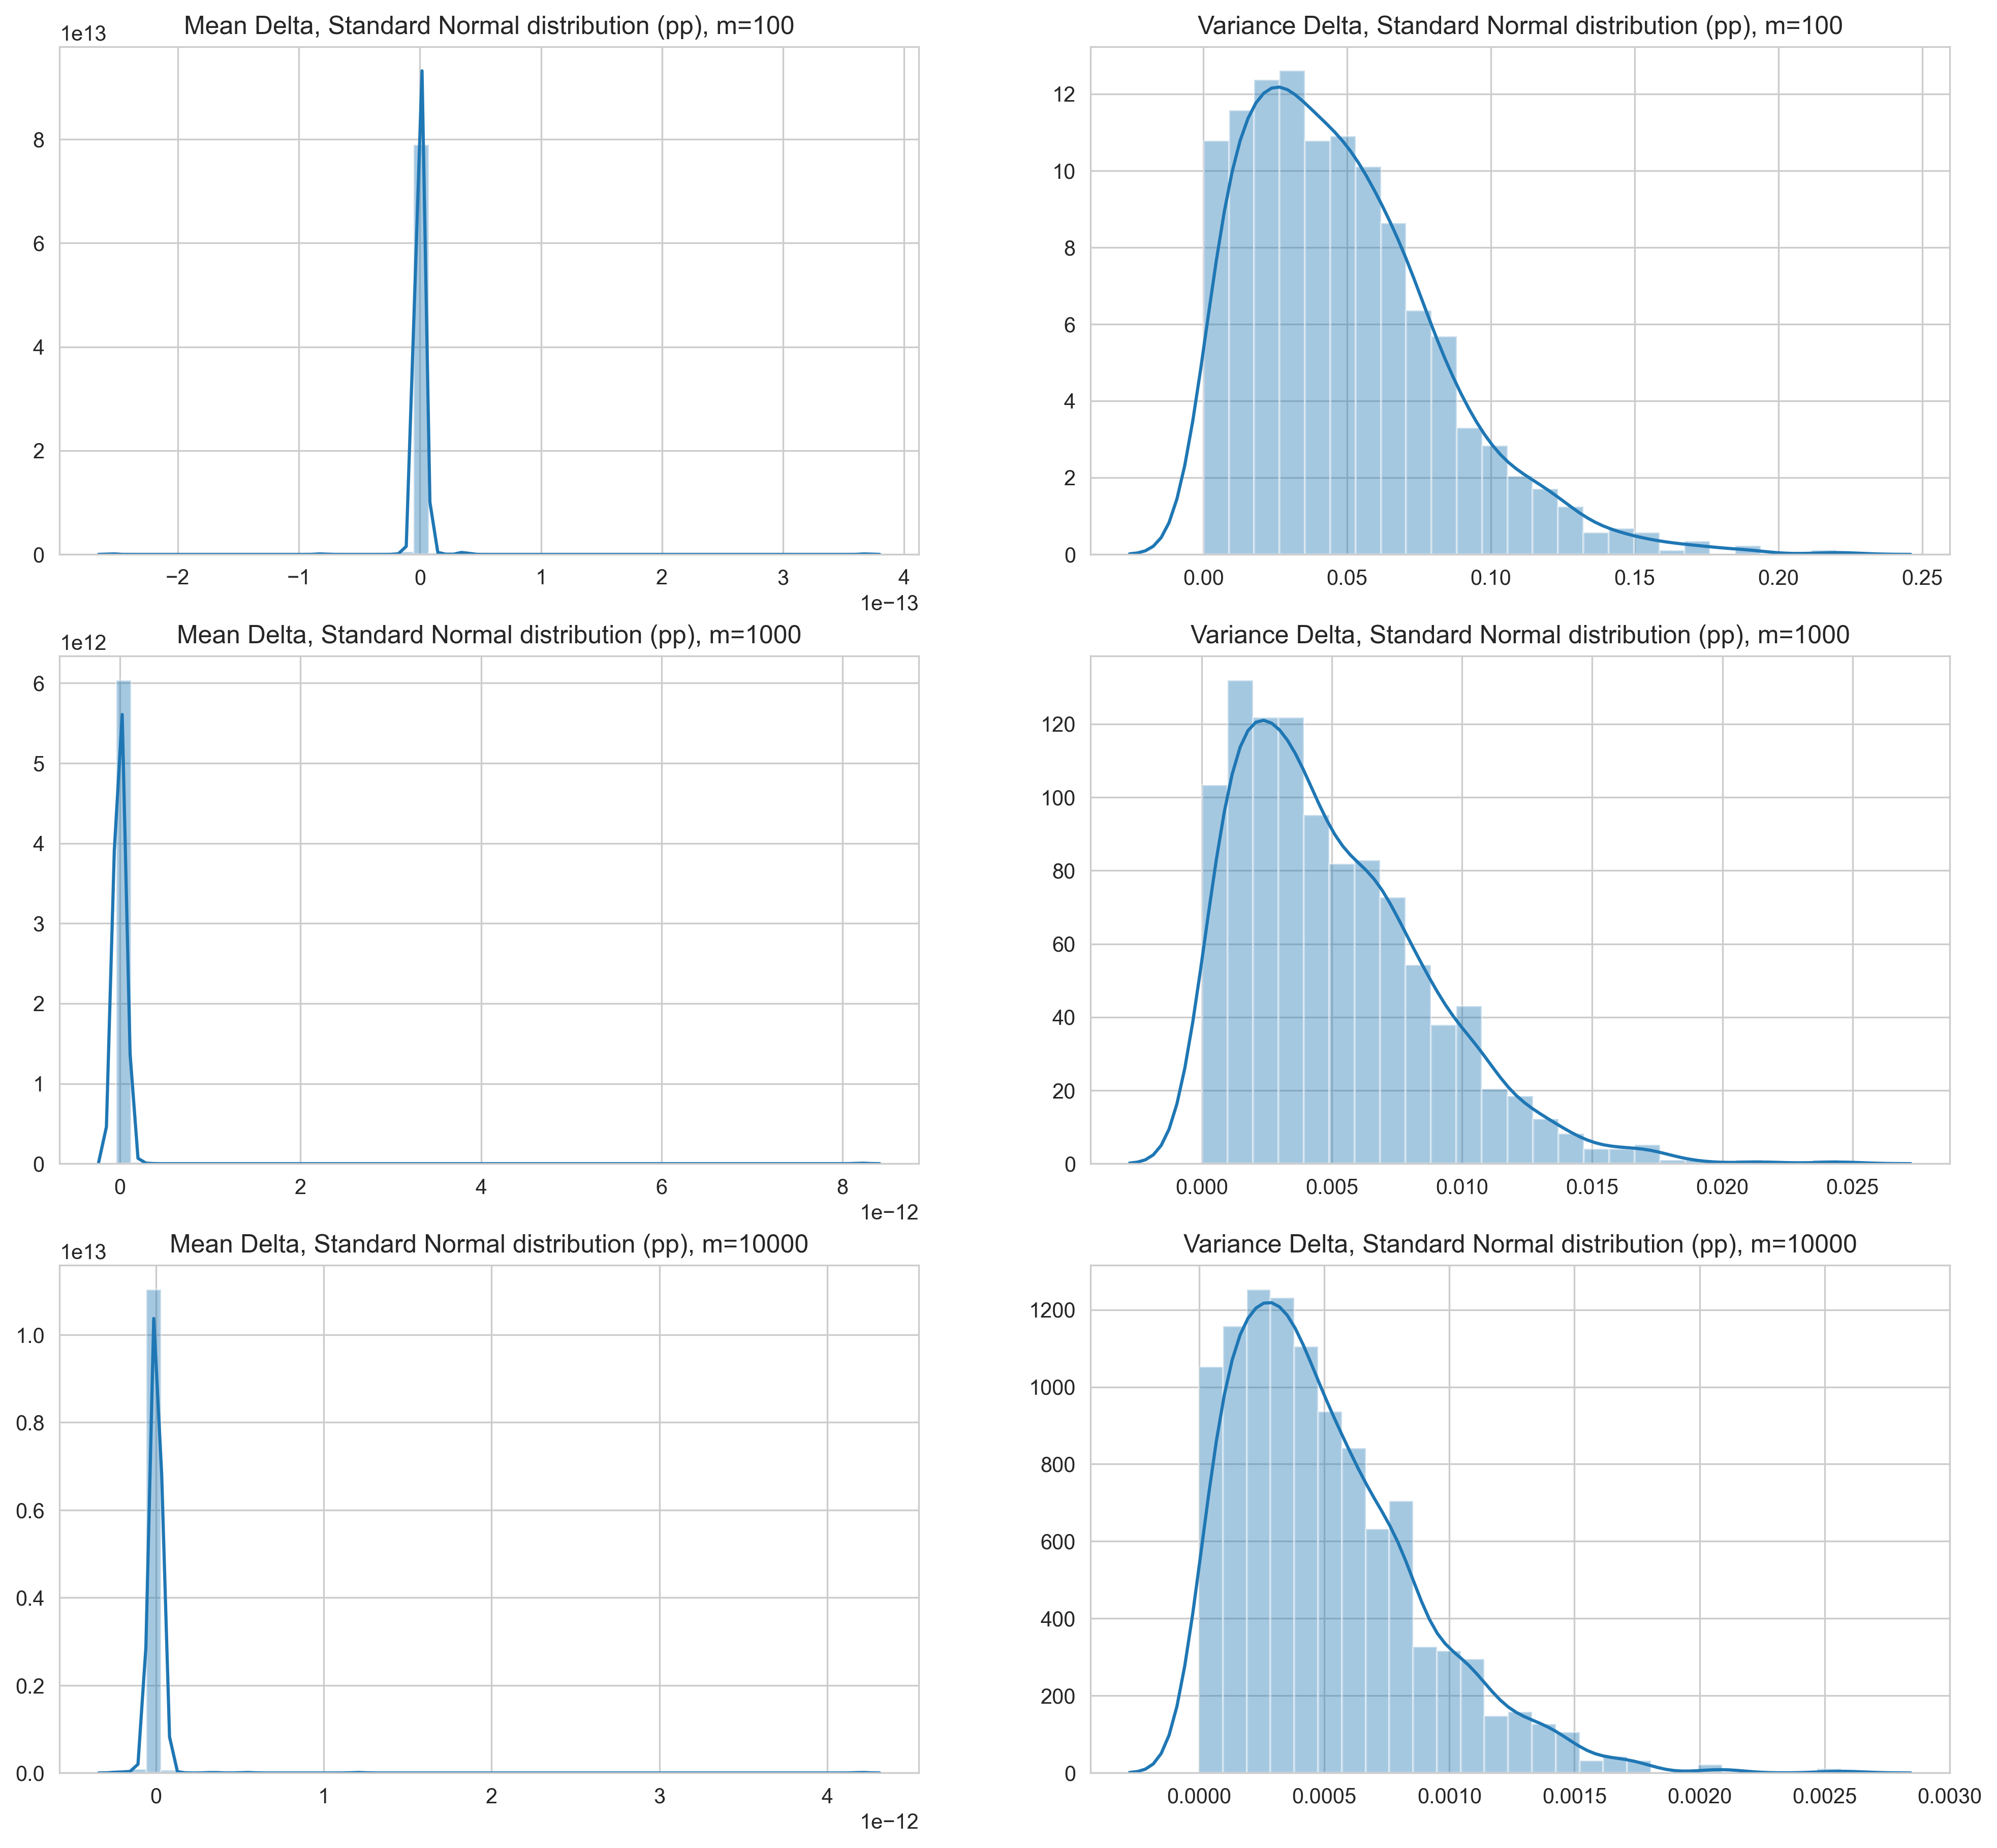

In [16]:
simulate_and_plot(rounds=1000, possible_num_samples=[100, 1000, 10000], sub_sample_range=np.arange(3, 10), 
                  data_and_stats_fn=snd_data_and_stats, dist_type="Standard Normal")

### Binomial Distribution

For this experiment, note that we're assuming unknown `n` and `p` values, and we use the same stats function defined for standard normal distributions.

In [17]:
def binom_data_and_stats(idx: int, num_samples: int) -> Tuple[np.ndarray, Tuple[float, float]]:
    del idx
    n = np.random.randint(5, 20)
    p = np.random.random()
    data = np.random.binomial(n, p, num_samples)
    return data, snd_stats(data)

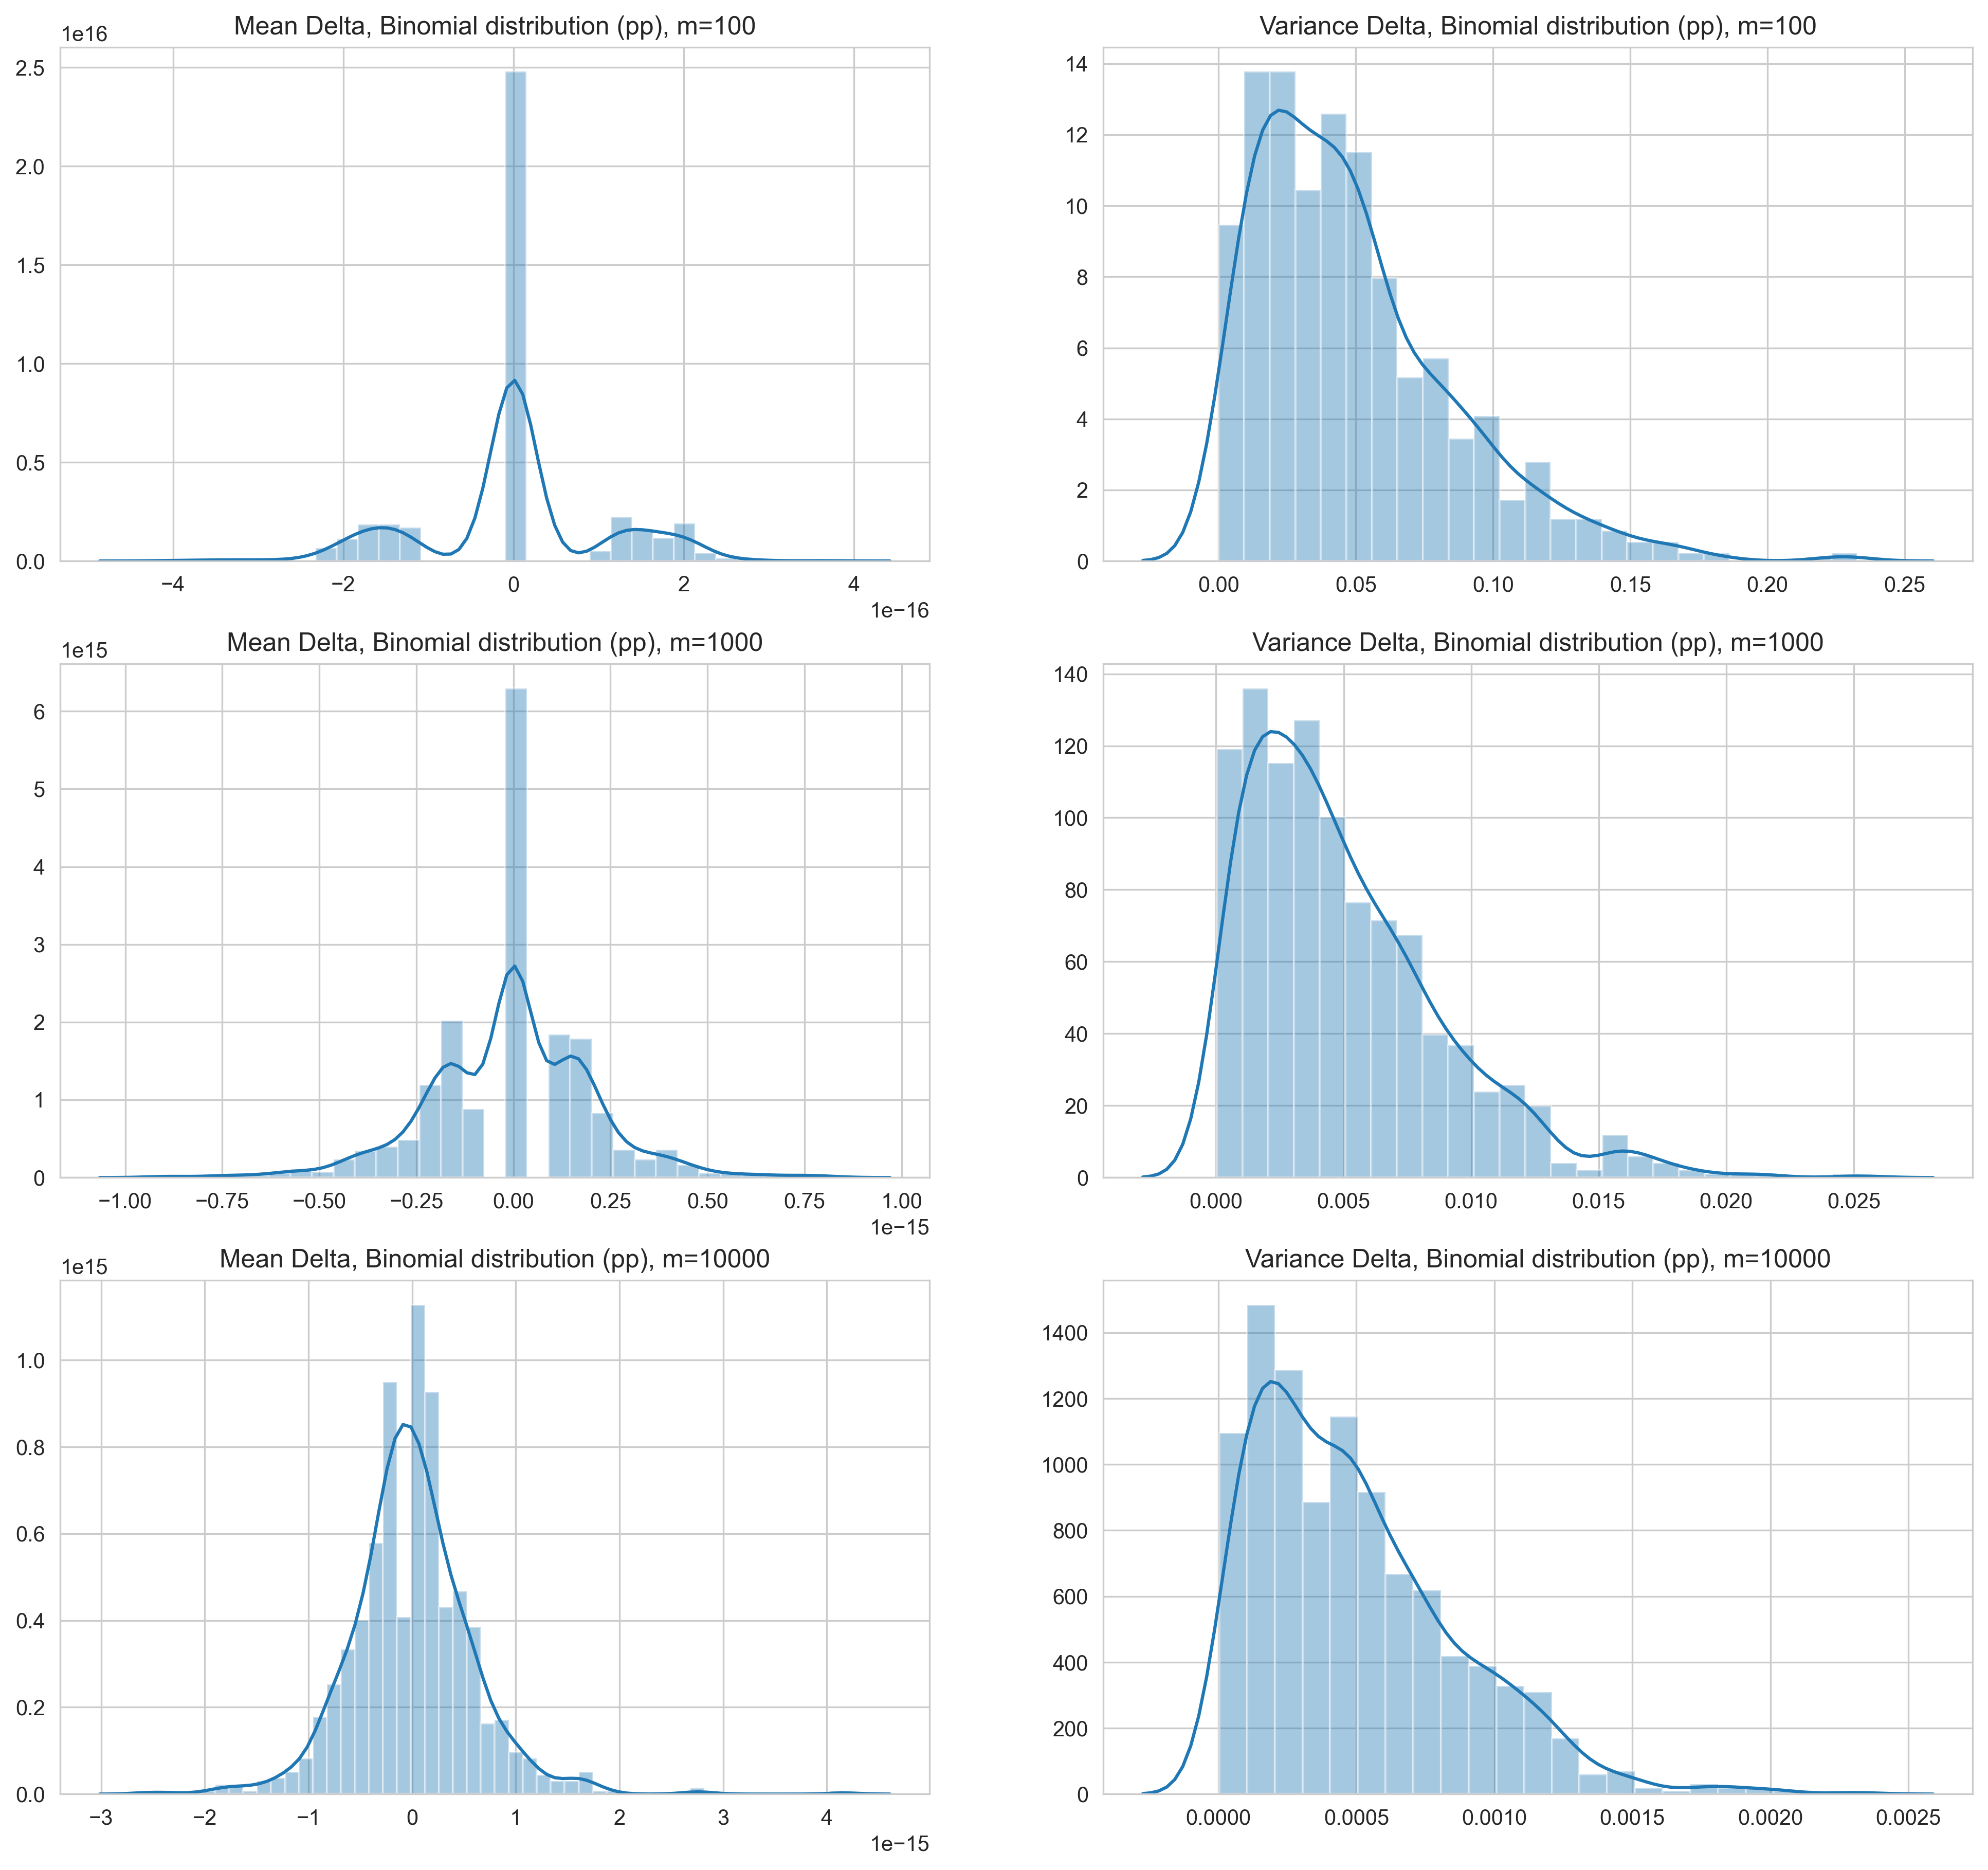

In [18]:
simulate_and_plot(rounds=1000, possible_num_samples=[100, 1000, 10000], sub_sample_range=np.arange(3, 10), 
                  data_and_stats_fn=binom_data_and_stats, dist_type="Binomial")

## Observations

  - For both distributions, the mean is fairly reliable.
  - The variance, on the other hand, seems to be consistently overestimated with the Welford and Chan et al's method.
  - For small samples sizes of roughly 100 values, percentage difference is relatively high - making the estimate unreliable - up to ~30% delta in the extreme case
  - For larger sample sizes, the percentage change reduces - the higher the magnitude of the sample size, the lower the magnitude of the delta
    - At 1000 samples, we get 2.5% error, and at 10000 samples, we get 0.3% delta as extreme values